In [11]:
import modules as md 
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs
%matplotlib inline
import cartopy.feature as cfeature
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [13]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0",
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [14]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['NorESM2-LM'], activity_id = ['CMIP'], experiment_id=['piControl'], table_id=['Ofx'], variable_id=['areacello'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/piControl...,NaN,20210118


In [80]:
file_dir ='s3://escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
remote_files = s3.glob(file_dir)
x=remote_files[10:]
fileset = [s3.open(file) for file in remote_files[10:]]

da = xr.open_mfdataset(fileset, combine='by_coords')
weight= weighted_temporal_mean(da,'chlos')

aa=weight.groupby("time.year").sum(dim='time')

now1=aa.isel(year = slice(30,None))
now=now1.mean('year')

clim1= aa.isel(year = slice(None,30))
clim=clim1.mean('year')

anm=(now-clim)/clim

#now

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


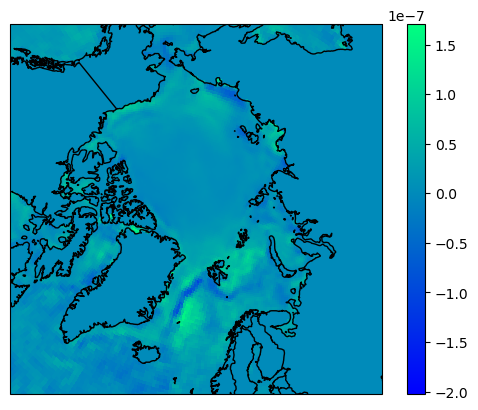

In [82]:
fig=plt.figure()
ax=fig.add_subplot(projection=ccrs.NorthPolarStereo())#NearsidePerspective())
ax.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#'viridis',Greens
cc=ax.pcolormesh(anm.longitude,anm.latitude,anm,cmap='winter',transform=ccrs.PlateCarree())
fig.colorbar(cc,ax=ax)

In [87]:
remote_files = s3.glob(file_dir)
x=remote_files[10:]
fileset = [s3.open(file) for file in remote_files[9:]]
fileset

da = xr.open_mfdataset(fileset, combine='by_coords')
weight= weighted_temporal_mean(da,'chlos')

aa=weight.groupby("time.year").sum(dim='time')

now1=aa.isel(year = slice(40,None))
now=now1.mean('year')

clim1= aa.isel(year = slice(None,30))
clim=clim1.mean('year')

anm=(now-clim)


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


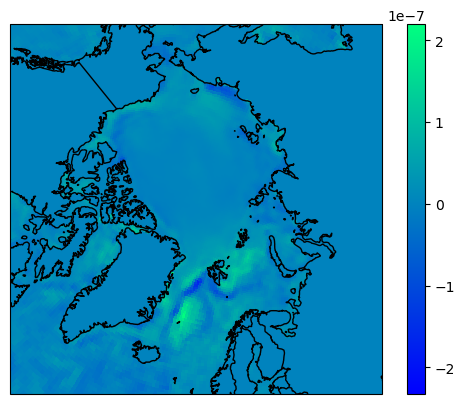

In [88]:
fig=plt.figure()
ax=fig.add_subplot(projection=ccrs.NorthPolarStereo())#NearsidePerspective())
ax.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax.stock_img()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#'viridis',Greens
cc=ax.pcolormesh(anm.longitude,anm.latitude,anm,cmap='winter',transform=ccrs.PlateCarree())
fig.colorbar(cc,ax=ax)

In [17]:
def anomaly (var):
    
    if var == 'chlos':
        file_dir ='s3://escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
    if var=='dmsos':
        file_dir ='s3://escience2022/Ada/monthly/dmsos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
    if var=='emidms':
        file_dir ='s3://escience2022/Ada/monthly/emidms_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
    if var == 'siconc':
        file_dir='s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
    if var == 'tos':
        file_dir='s3://escience2022/Ada/monthly/tos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
        
    remote_files = s3.glob(file_dir)
    x=remote_files[10:]
    fileset = [s3.open(file) for file in remote_files[10:]]

    da = xr.open_mfdataset(fileset, combine='by_coords')
    weight= weighted_temporal_mean(da,var)

    aa=weight.groupby("time.year").sum(dim='time')

    now1=aa.isel(year = slice(30,None))
    now=now1.mean('year')

    clim1= aa.isel(year = slice(None,30))
    clim=clim1.mean('year')

    fractional_anm=(now-clim)/clim
    anm= (now-clim)
    
    anomaly=[anm,fractional_anm]
    return anomaly


        
        
        
        

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


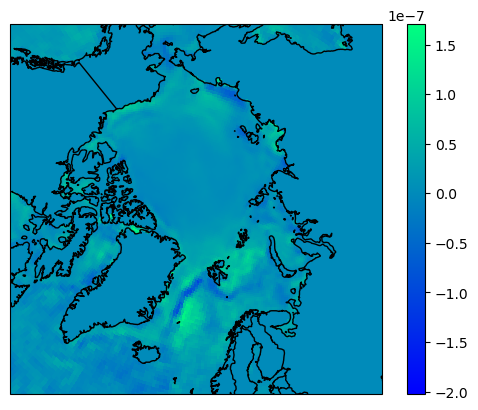

In [18]:
var='chlos'
anm1=anomaly(var)[0]

fig=plt.figure()
ax1=fig.add_subplot(projection=ccrs.NorthPolarStereo())#NearsidePerspective())
ax1.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax1.stock_img()
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.COASTLINE)

#'viridis',Greens
cc=ax1.pcolormesh(anm1.longitude,anm1.latitude,anm1,cmap='winter',transform=ccrs.PlateCarree())
fig.colorbar(cc,ax=ax1)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


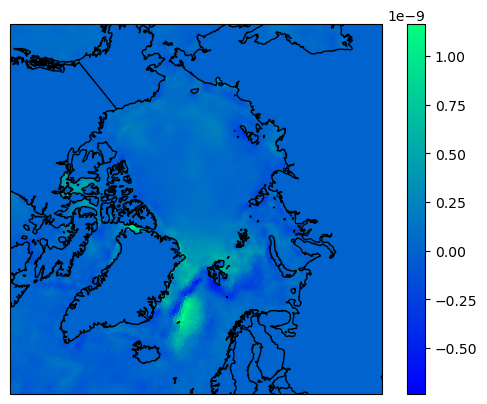

In [19]:
var='dmsos'
anm1=anomaly(var)[0]

fig=plt.figure()
ax1=fig.add_subplot(projection=ccrs.NorthPolarStereo())#NearsidePerspective())
ax1.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax1.stock_img()
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.COASTLINE)

#'viridis',Greens
cc=ax1.pcolormesh(anm1.longitude,anm1.latitude,anm1,cmap='winter',transform=ccrs.PlateCarree())
fig.colorbar(cc,ax=ax1)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


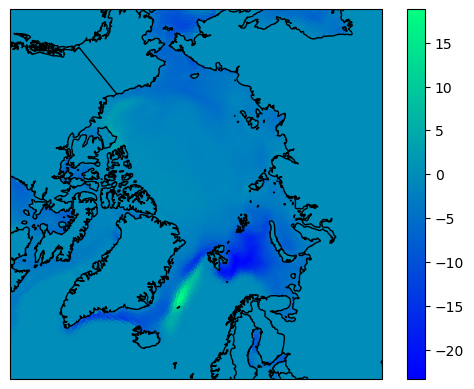

In [20]:
var='siconc'
anm1=anomaly(var)[0]

fig=plt.figure()
ax1=fig.add_subplot(projection=ccrs.NorthPolarStereo())#NearsidePerspective())
ax1.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax1.stock_img()
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.COASTLINE)

#'viridis',Greens
cc=ax1.pcolormesh(anm1.longitude,anm1.latitude,anm1,cmap='winter',transform=ccrs.PlateCarree())
fig.colorbar(cc,ax=ax1)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


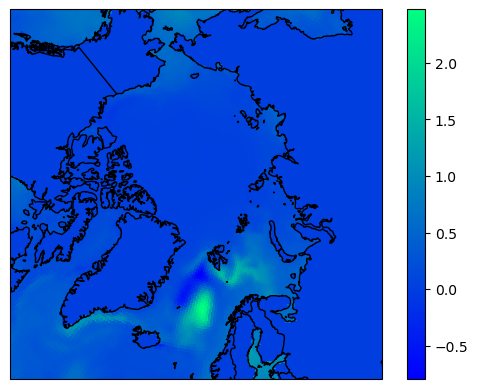

In [21]:
var='tos'
anm1=anomaly(var)[0]

fig=plt.figure()
ax1=fig.add_subplot(projection=ccrs.NorthPolarStereo())#NearsidePerspective())
ax1.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax1.stock_img()
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.COASTLINE)

#'viridis',Greens
cc=ax1.pcolormesh(anm1.longitude,anm1.latitude,anm1,cmap='winter',transform=ccrs.PlateCarree())
fig.colorbar(cc,ax=ax1)

In [22]:
#trends over the last 30 years

In [48]:
file_dir ='s3://escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
remote_files = s3.glob(file_dir)
x=remote_files[10:]
fileset = [s3.open(file) for file in remote_files[13:]]

da = xr.open_mfdataset(fileset, combine='by_coords')
weighted_mean= weighted_temporal_mean(da,'chlos')

#JJA_annual = mar['MELT'].where(mar['MELT']['TIME.season'] == 'JJA').groupby('TIME.year').mean(dim='TIME')

yearly_data=weighted_mean.groupby("time.year").sum(dim='time')
years_30=yearly_data.isel(year = slice(5,None))

years_30
#years_30.plot(col='year', col_wrap=5)

<xarray.DataArray (year: 30, j: 385, i: 360)>
dask.array<getitem, shape=(30, 385, 360), dtype=float64, chunksize=(1, 385, 360), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * year       (year) int64 1985 1986 1987 1988 1989 ... 2011 2012 2013 2014

In [49]:
da

<xarray.Dataset>
Dimensions:             (time: 420, bnds: 2, j: 385, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 1980-01-16 12:00:00 ... 2014-12-16 12:0...
  * j                   (j) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384 385
  * i                   (i) int32 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
    latitude            (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    vertices_latitude   (time, j, i, vertices) float64 dask.array<chunksize=(120, 385, 360, 4), meta=np.ndarray>
    vertices_longitude  (time, j, i, vertices) float64 dask.array<chunksize=(120, 385, 360, 4), meta=np.ndarray>
    chlos               (time, j, i) float32 dask.array<chunksize=(120, 385, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               chlos
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.6.0
    tracking_id:               hdl:21.14100/0c274613-e9d3-438b-988f-c3d8a74fb023

In [45]:
vals = years_30.values 
years = years_30.year.values


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [47]:
vals2 = vals.reshape(len(years), -1)
regressions = np.polyfit(years, vals2, 1)
trends = regressions[0,:].reshape(vals.shape[1], vals.shape[2])
trends

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
da['years_30']=(['years','j','i'],years_30.values) 

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


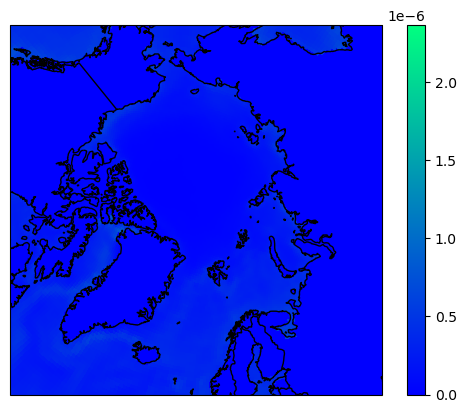

In [63]:
var='chlos'
anm1=anomaly(var)[0]

fig=plt.figure()
ax1=fig.add_subplot(projection=ccrs.NorthPolarStereo())#NearsidePerspective())
ax1.set_extent([0, 360, 60, 90], crs=ccrs.PlateCarree())
ax1.stock_img()
ax1.add_feature(cfeature.BORDERS)
ax1.add_feature(cfeature.COASTLINE)

#'viridis',Greens
cc=ax1.pcolormesh(years_30.longitude,years_30.latitude,years_30.mean(dim='year'),cmap='winter',transform=ccrs.PlateCarree())
fig.colorbar(cc,ax=ax1)

In [55]:
years_30

<xarray.DataArray (year: 30, j: 385, i: 360)>
dask.array<getitem, shape=(30, 385, 360), dtype=float64, chunksize=(1, 385, 360), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * year       (year) int64 1985 1986 1987 1988 1989 ... 2011 2012 2013 2014

In [60]:
years_30.longitude

<xarray.DataArray 'longitude' (j: 385, i: 360)>
dask.array<copy, shape=(385, 360), dtype=float64, chunksize=(385, 360), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    bounds:         vertices_longitude

In [57]:
ds_years_30 = xr.Dataset({'year':years_30.year,'j': years_30.j, 'i': years_30.i})
ds_years_30['years_30']=(['year','j','i'],years_30.values)

In [59]:
ds_years_30.mean(dim='year')

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

In [ ]:

import pymannkendall as mk

import numpy as np



def trend(ds, variable, season):


# create a dataset with same lon and lat as the precipitation dataset

ds_trend = xr.Dataset({'lat': ds.lat,'lon': ds.lon})

# add ds_trend_DJF to ds_NorESM2_MM_precip_season_trend

ds_trend['mk_trend'] = (['lat', 'lon'], np.zeros(ds.lat.shape[0], ds.lon.shape[0])*np.nan)

ds_trend['mk_intercept'] = (['lat', 'lon'], np.zeros(ds.lat.shape[0], ds.lon.shape[0])*np.nan)

ds_trend['mk_p_val'] = (['lat', 'lon'], np.zeros(ds.lat.shape[0], ds.lon.shape[0])*np.nan) 


for ilat in range(ds[variable].shape[1]):

for ilon in range(ds[variable].shape[2]):

ts = ds[variable][:, ilat, ilon]

results = mk.original_test(ts)

ds_trend['mk_trend'][ilat, ilon] = results[7]

ds_trend['mk_intercept'][ilat, ilon] = results[8]

ds_trend['mk_p_val'][ilat, ilon] = results[2]

return ds_trend